In [1]:
import os
import random

import numpy as np
import torch

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

import matplotlib.pyplot as plt
from darts.models import RNNModel, TransformerModel, NBEATSModel

from dysts.flows import *
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

from base.data import load_or_generate_and_save
from base.plot import plot_3d_trajectories, plot_3d_predictions_vs_ground_truth

[2022-03-22 10:28:23,934] WARNING | darts.models | Support for AutoARIMA is not available.To enable it, install u8darts[pmdarima] or u8darts[all].
[2022-03-22 10:28:23,937] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).


# Experimental settings

In [2]:
data_params = {
    'n_trajectories': 5000,
    'trajectory_length': 5000
}
model_params = {
    'train_epochs': 5,
    'common': {
        'input_chunk_length': 1,
        'output_chunk_length': 1
    },
    'RNNModel': {
        'model': 'GRU'
    },
    'NBEATSModel': {
        'num_blocks': 4,
        'num_stacks': 32,
        'layer_widths': 64
    },
    'TransformerModel': {

    }
}

data_params_string = '_'.join([f'{k}_{v}' for k, v in data_params.items()])
common_params_string = '_'.join([f'{k}_{v}' for k, v in model_params['common'].items()])

experiment_name = f'{data_params_string}_{common_params_string}'

models = [
    Model(**model_params['common'], **model_params[Model.__name__])
    for Model in [
        NBEATSModel,
        RNNModel,
        TransformerModel
    ]
]

NameError: name 'NeuralODE' is not defined

In [3]:
if not os.path.isdir('results'):
    os.mkdir('results')
os.mkdir(f'results/{experiment_name}')

## Load / generate train data

In [4]:
train_set = load_or_generate_and_save(f'data/{data_params_string}_train.npy', chaos_model=lorenz,
                                      data_params=data_params, ic_fun=lambda: 20 * np.random.rand(3))

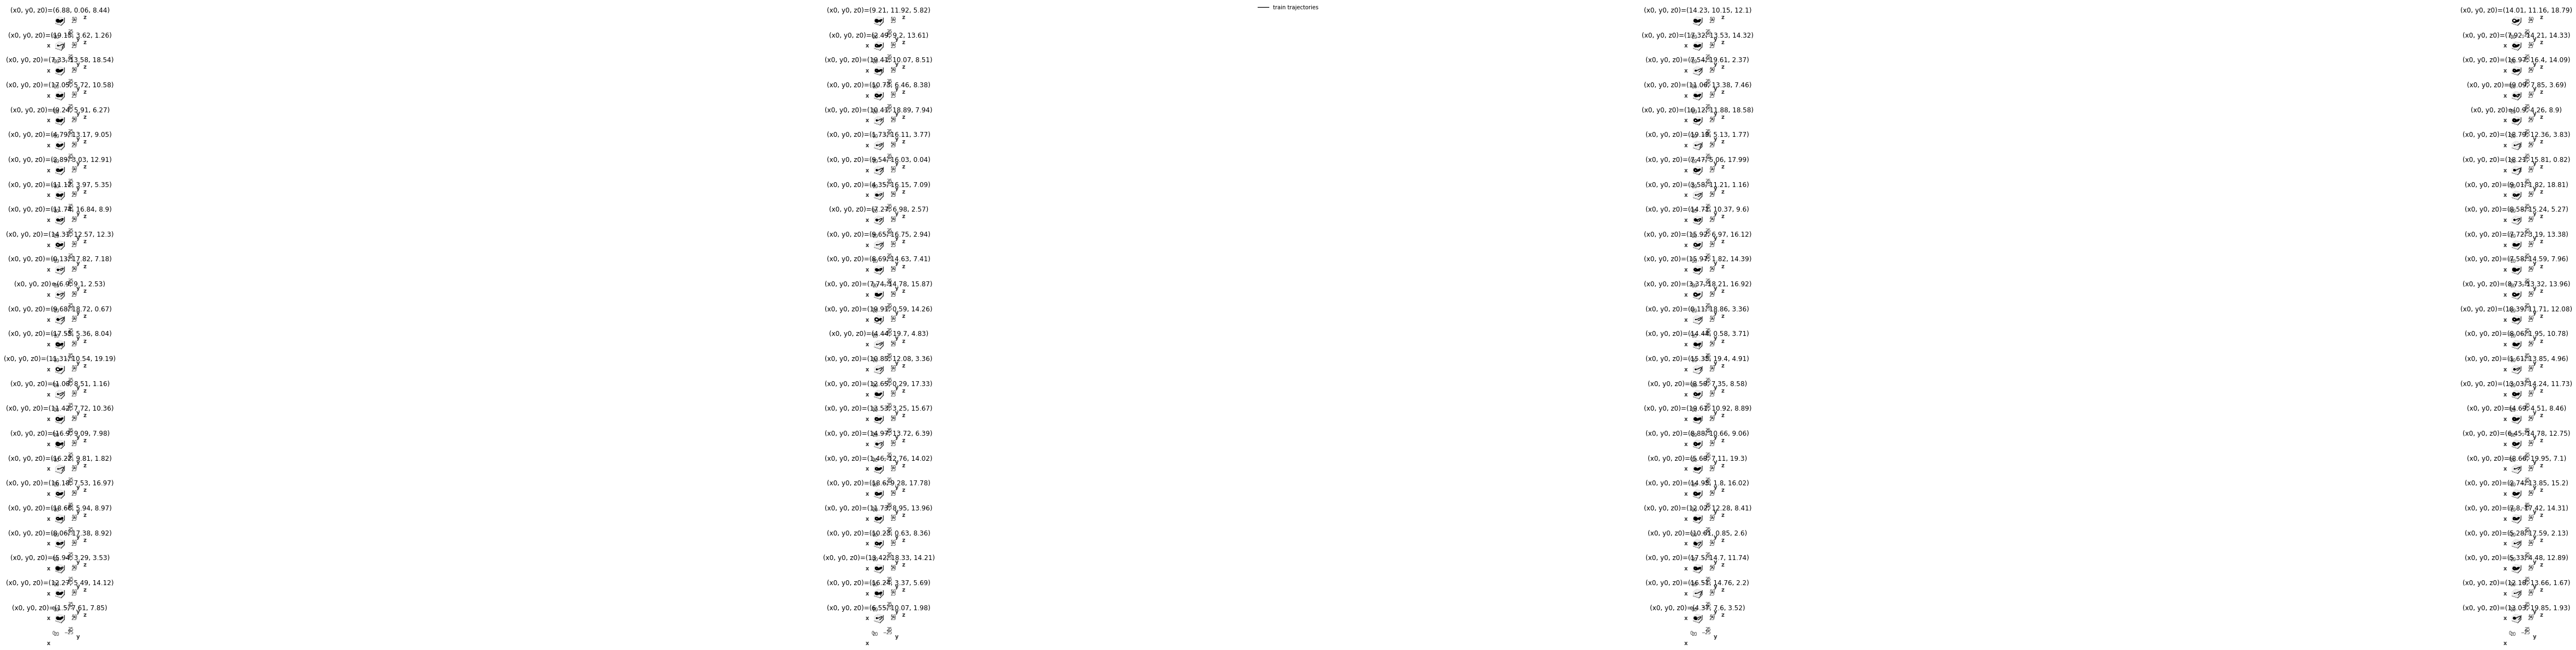

In [7]:
plot_3d_trajectories([train_set], labels=['train trajectories'], n_plots=100);

## Load / generate test data

In [5]:
test_set = load_or_generate_and_save(f'data/{data_params_string}_test.npy', chaos_model=lorenz, data_params=data_params,
                                     ic_fun=lambda: -10 * np.random.rand(3))

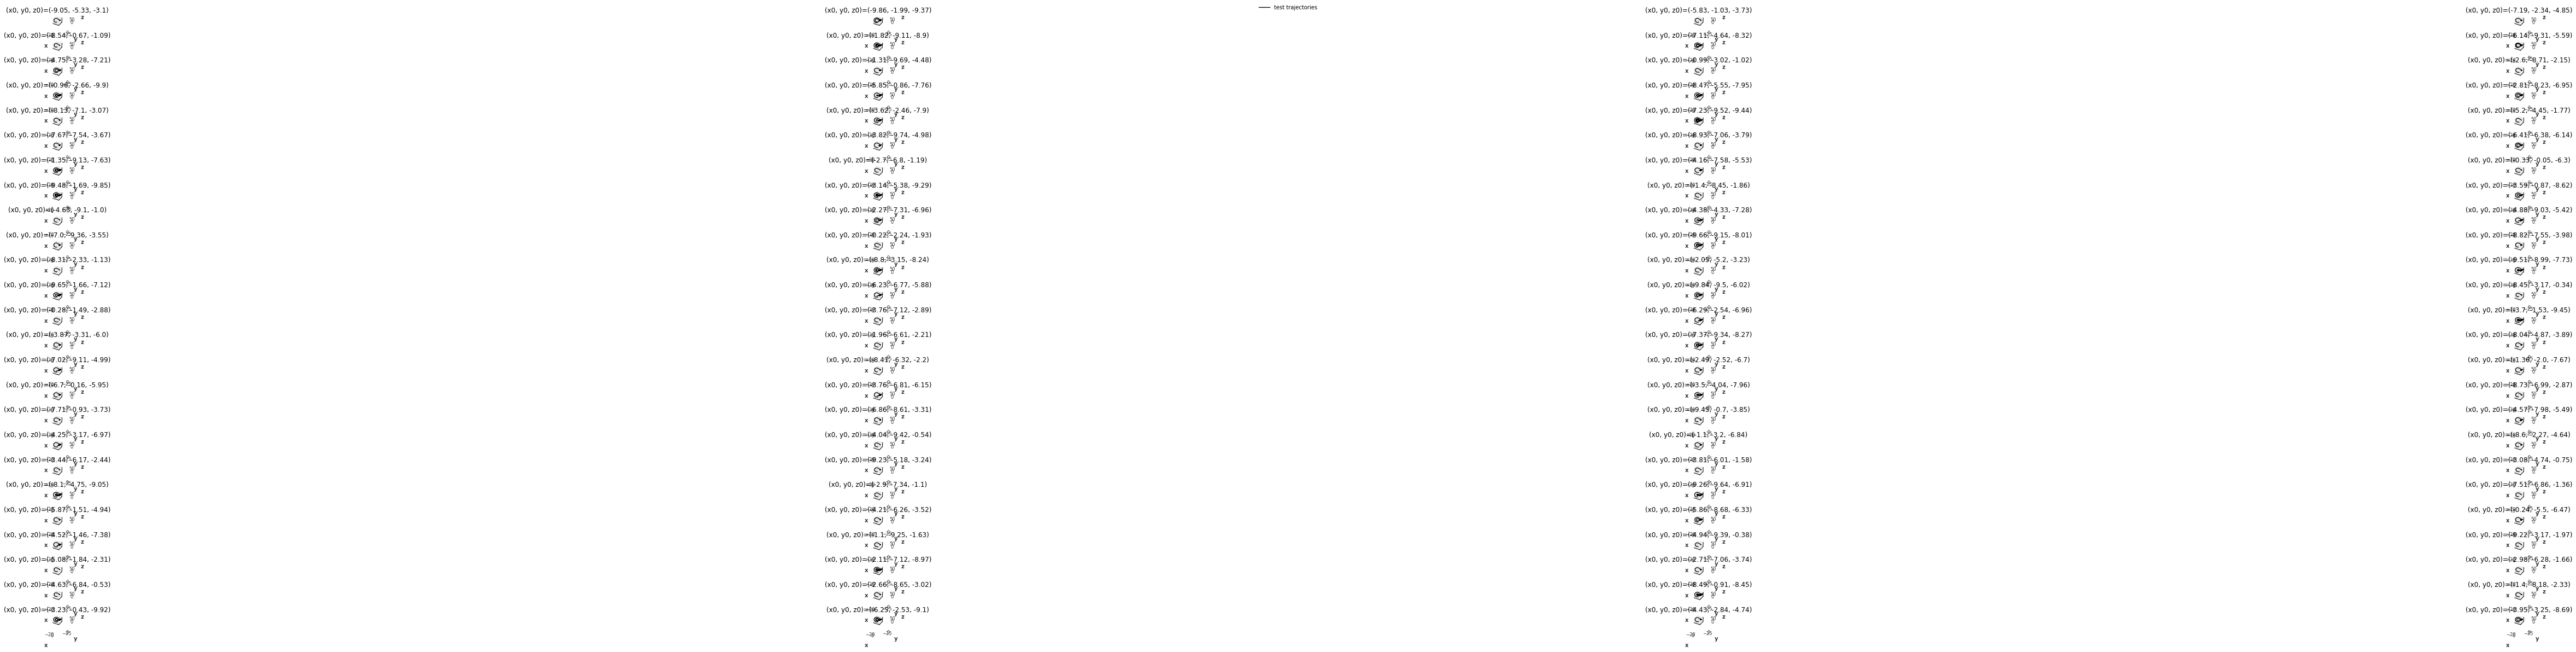

In [9]:
plot_3d_trajectories([test_set], labels=['test trajectories'], n_plots=100);

## Train and save models

In [6]:
for model in models:
    model_params_string = '_'.join([f'{k}_{v}' for k, v in model_params[model.__class__.__name__].items()])
    wandb_logger = WandbLogger(project="chaos-forecasting", name=f'{model.__class__.__name__}_{model_params_string}')
    trainer = Trainer(logger=wandb_logger, precision=64, max_epochs=model_params['train_epochs'])
    model.fit(train_set, epochs=model_params['train_epochs'], trainer=trainer)
    model.save_model(
        f'experiments/{experiment_name}/{model.__class__.__name__}_{model_params_string}_{model.model_name}.pth.tar')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-03-21 11:21:25,343] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 99900 samples.
[2022-03-21 11:21:25,343] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 99900 samples.
[2022-03-21 11:21:25,642] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-21 11:21:25,642] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
wandb: Currently logged in as: streitlua (use `wandb login --relogin` to force relogin)



  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 117 K 
-----------------------------------------
117 K     Trainable params
183       Non-trainable params
117 K     Total params
0.937     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [6]:
from darts.models.forecasting.torch_forecasting_model import TorchForecastingModel
import os

models = [TorchForecastingModel.load_model(f'{experiment_name}/models/{f}') for f in os.listdir('models')]

# Show predictions

In [7]:
plot_3d_predictions_vs_ground_truth(models, train_set, data_params, model_params, n_plots=100)
plt.savefig(f'experiments/{experiment_name}/predictions_train.png')

Predicting: 3122it [00:00, ?it/s]

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [ ]:
plot_3d_predictions_vs_ground_truth(models, test_set, data_params, model_params)
plt.savefig(f'experiments/{experiment_name}/predictions_test.png')